# Car Price Prediction – Machine Learning Project

This project aims to develop a machine learning model capable of accurately predicting the price of used cars based on various technical and categorical attributes such as mileage, year, engine power, fuel type, and brand.


In [4]:
import os
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

!pip freeze >> requirements.txt

## Loading the Dataset

In [19]:
df = pd.read_excel("cars.xlsx")
df.to_csv('cars.csv', index=False)

In [5]:
df = pd.read_csv("cars.csv")
print("\nDataset Loaded. Shape:", df.shape)

print('\nInfo:')
print(df.info())


Dataset Loaded. Shape: (65535, 10)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            65535 non-null  object 
 1   model            65535 non-null  object 
 2   price_in_pln     65535 non-null  float64
 3   mileage          65535 non-null  object 
 4   gearbox          65535 non-null  object 
 5   engine_capacity  65535 non-null  object 
 6   fuel_type        65535 non-null  object 
 7   city             65535 non-null  object 
 8   voivodeship      65535 non-null  object 
 9   year             65535 non-null  object 
dtypes: float64(1), object(9)
memory usage: 5.0+ MB
None


In [6]:
df.head()

,brand,model,price_in_pln,mileage,gearbox,engine_capacity,fuel_type,city,voivodeship,year
0,alfa-romeo,Alfa Romeo Spider 2.0-16 TSpark,14700.0,133760,manual,1970,Benzyna,Łask,Łódzkie,1998
1,alfa-romeo,Alfa Romeo GTV 2.0 16v TSpark,14000.0,133760,manual,1970,Benzyna,Mława,Mazowieckie,1998
2,alfa-romeo,Alfa Romeo 164 2.0 TSpark Super,4500.0,227000,manual,1970,Benzyna,Chełmża,Kujawsko-pomorskie,1996
3,alfa-romeo,Alfa Romeo Spider 2.0 TSpark,17100.0,227000,manual,1970,Benzyna,Jasło,Podkarpackie,1996
4,alfa-romeo,Alfa Romeo 156 1.6 TSpark 16v,3900.0,239000,manual,1995,Benzyna+LPG,Pabianice,Łódzkie,1995


## Data Exploration and Preprocessing
- Removing rows with missing values
- Removing rows with misplaced values
- Removing rows with duplicate values
- Outlier detection and filtering

In [ ]:
def clean_a_column(df, column_name, should_be_numeric):    
    if should_be_numeric:
        mask = pd.to_numeric(df[column_name], errors='coerce').notna()
        to_be_saved = df[~mask].copy()
        df = df[mask].copy()
        df[column_name] = pd.to_numeric(df[column_name])
    else:
        mask = pd.to_numeric(df[column_name], errors='coerce').isna()
        to_be_saved = df[~mask].copy()
        df = df[mask].copy()
        df[column_name] = df[column_name].astype(str)
    return df, to_be_saved

def clean_all_columns(df):
    numeric_columns = ['mileage', 'engine_capacity', 'year', 'price_in_pln']
    categorical_columns = ['brand', 'model', 'gearbox', 'fuel_type', 'city', 'voivodeship']    
    all_removed_rows = pd.DataFrame()
    
    for num_col in numeric_columns:
        print(f"Processing numeric column: {num_col}")
        df, removed_rows = clean_a_column(df, num_col, True)
        all_removed_rows = pd.concat([all_removed_rows, removed_rows])
    
    for cat_col in categorical_columns:
        print(f"Processing categorical column: {cat_col}")
        df, removed_rows = clean_a_column(df, cat_col, False)
        all_removed_rows = pd.concat([all_removed_rows, removed_rows])
    
    all_removed_rows = all_removed_rows.drop_duplicates()
    # all_removed_rows.to_csv('removed_rows.csv', index=False)
    # print(f"Saved {len(all_removed_rows)} removed rows to 'removed_rows.csv'")
    return df, all_removed_rows


df, all_removed_rows = clean_all_columns(df)

Processing numeric column: mileage
Processing numeric column: engine_capacity
Processing numeric column: year
Processing numeric column: price_in_pln
Processing categorical column: brand
Processing categorical column: model
Processing categorical column: gearbox
Processing categorical column: fuel_type
Processing categorical column: city
Processing categorical column: voivodeship


The rows having misplaced values, that previously were removed, are now corrected and concatenated. This allows the model to learn from more data, out of the 3935 removed rows 2930 have been corrected, improving its performance and accuracy. 

Example: 
| Brand | Model             | Price | Mileage   | Gearbox   | Engine Capacity | Fuel Type | City     | Voivodeship | Year
| ----- | ----------------- | ----------- | ----------- | --------- | ---- | ------- | -------- | ----------- | --------
| Audi  | Audi RS Q3        | 365500.00  | Elektryczny | Automatic | 2023 | 5 km    | Warszawa | Mazowieckie | 5 km
| Audi  | Audi RS e-tron GT | 564600.00  | Benzyna     | Automatic | 2023 | 5 km    | Warszawa | Mazowieckie | 3 996 cm3


While the first row has to be removed, the second row can be corrected to:
| Brand | Model             | Price | Mileage | Gearbox   | Engine Capacity | Fuel Type | City     | Voivodeship | Year |
| ----- | ----------------- | ----------- | ------- | --------- | --------------------- | --------- | -------- | ----------- | ---- |
| Audi  | Audi RS e-tron GT | 564600.00  | 5    | Automatic | 3996                 | Benzyna   | Warszawa | Mazowieckie | 2023 |


In [8]:
def correct_misplaced_row(row_data, fuel_types, years, cities, voivodeships, gearbox_types):
    if isinstance(row_data, list):
        columns = ['brand', 'model', 'price_in_pln', 'mileage', 'gearbox', 'engine_capacity', 'fuel_type', 'city', 'voivodeship', 'year']
        row_data = dict(zip(columns, row_data))
    
    def is_mileage(value):
        return isinstance(value, str) and 'km' in value.lower()
    
    def is_engine_capacity(value):
        return isinstance(value, str) and 'cm3' in value.lower()
    
    def is_year(value):
        try:
            year_str = str(value).replace(' ', '').replace(',', '')
            year = int(year_str)
            return min(years) <= year <= max(years)
        except:
            return False
    
    def clean_mileage(value):
        """Remove 'km' from mileage value"""
        if isinstance(value, str):
            mileage_str = value.lower().replace('km', '').replace(' ', '').strip()
            return int(mileage_str)
        return value
    
    def clean_engine_capacity(value):
        """Remove 'cm3' from engine capacity value"""
        if isinstance(value, str):
            engine_capacity_str = value.lower().replace('cm3', '').replace(' ', '').strip()
            return int(engine_capacity_str)
        return value
    
    corrected_values = {
        'brand': row_data.get('brand', ''),
        'model': row_data.get('model', ''),
        'price_in_pln': row_data.get('price_in_pln', None),
        'mileage': None,
        'gearbox': None,
        'engine_capacity': None,
        'fuel_type': None,
        'city': None,
        'voivodeship': None,
        'year': None
    }
    
    values_to_check = []
    for key, value in row_data.items():
        if key not in ['brand', 'model', 'price_in_pln']:
            values_to_check.append(value)
    
    for value in values_to_check:
        if pd.isna(value) or value == '':
            continue
        value_str = str(value).strip()
        if value_str in fuel_types:
            corrected_values['fuel_type'] = value_str
        elif value_str in cities:
            corrected_values['city'] = value_str
        elif value_str in voivodeships:
            corrected_values['voivodeship'] = value_str
        elif any(value_str.lower() == g.lower() for g in gearbox_types if pd.notna(g)):
            corrected_values['gearbox'] = value_str
        elif is_mileage(value_str):
            corrected_values['mileage'] = clean_mileage(value_str)
        elif is_engine_capacity(value_str):
            corrected_values['engine_capacity'] = clean_engine_capacity(value_str)
        elif is_year(value_str):
            corrected_values['year'] = int(str(value_str).replace(' ', '').replace(',', ''))
    
    return corrected_values

def is_row_complete(row_dict):
    for key, value in row_dict.items():
        if value is None or value == '':
            return False
    return True

def process_removed_rows(all_removed_rows):
    fuel_types = df['fuel_type'].unique()
    years = df['year'].unique()
    gearbox_types = df['gearbox'].unique()
    cities = df['city'].unique()
    voivodeships = df['voivodeship'].unique()    
    corrected_rows = []
    
    for index, row in all_removed_rows.iterrows():
        try:
            corrected_row = correct_misplaced_row(row, fuel_types, years, cities, voivodeships, gearbox_types)
            if is_row_complete(corrected_row):
                corrected_rows.append(corrected_row)
                # print(f"Row {index} corrected and added:")
                # print(corrected_row)
            
        except Exception as e:
            print(f"Error processing row {index}: {e}")
    
    corrected_df = pd.DataFrame(corrected_rows)
    # corrected_df.to_csv("corrected_rows.csv", index=False)
    print(f"Total rows processed: {len(all_removed_rows)}")
    print(f"Complete rows saved: {len(corrected_rows)}")
    return corrected_df


corrected_df = process_removed_rows(all_removed_rows)
df = pd.concat([df, corrected_df], ignore_index=True)

Total rows processed: 3935
Complete rows saved: 2930


### Data Visualization – Price, Mileage, Engine Capacity and Year

In this section, we visualize the distribution and relationships of key numerical variables in the dataset that are expected to influence car prices.

* **Price distribution** helps to understand the overall price range and skewness.
* **Mileage distribution** gives insight into how used the cars are.
* **Engine Capacity distribution** shows the variety of engine sizes available.
* **Scatter plots** between:

  * **Price and Mileage** help detect depreciation trends.
  * **Price and Year** reveal how newer cars retain higher value.
  * **Price and Engine Capacity** show how engine size and price are related.

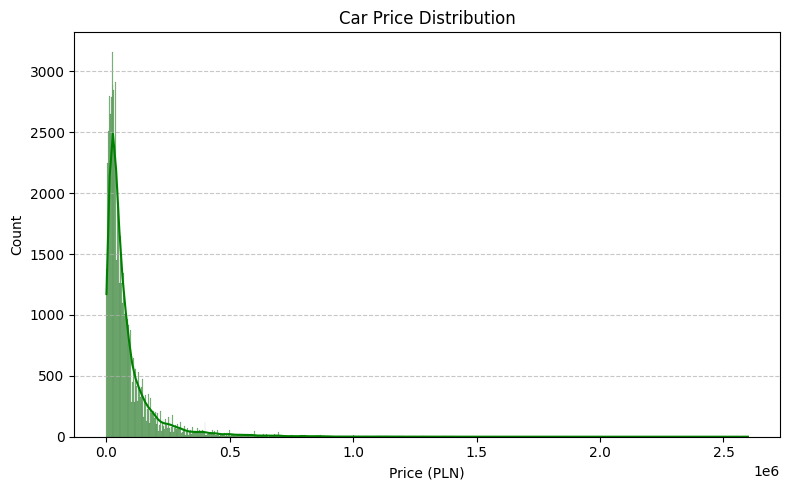

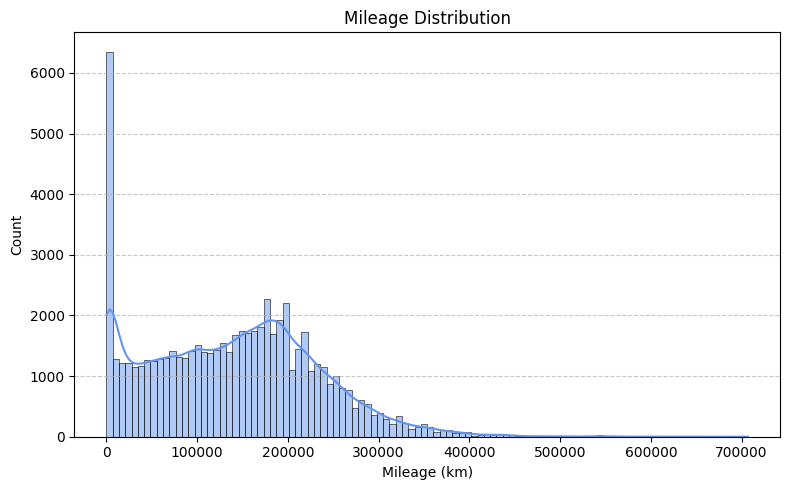

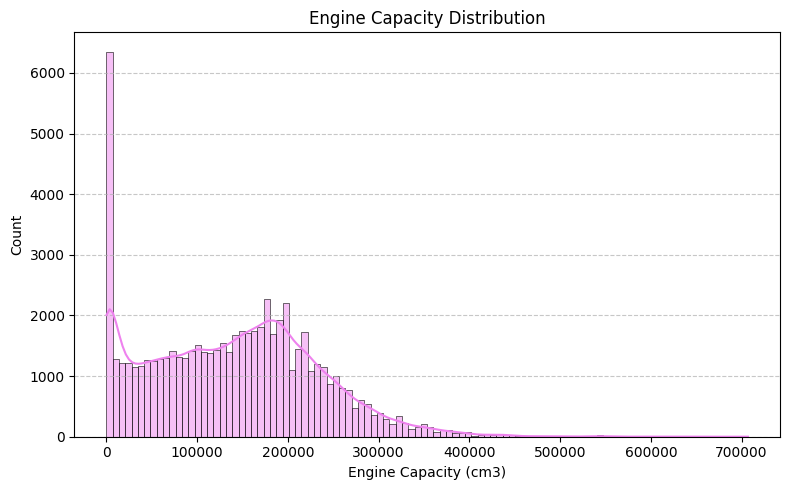

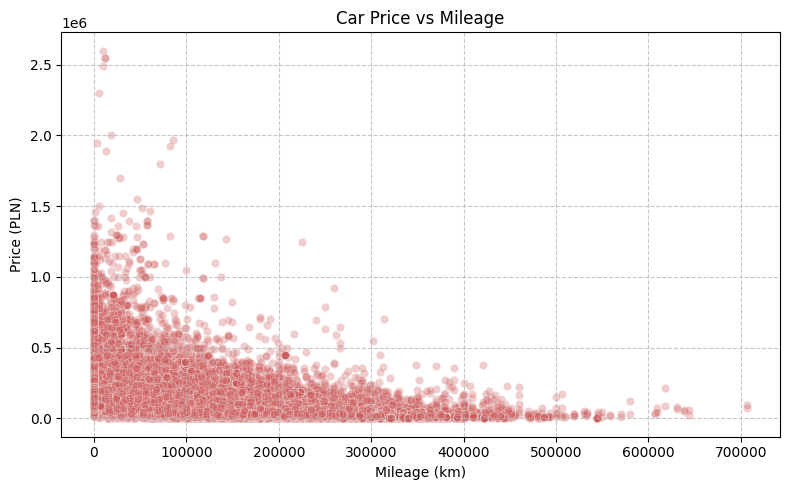

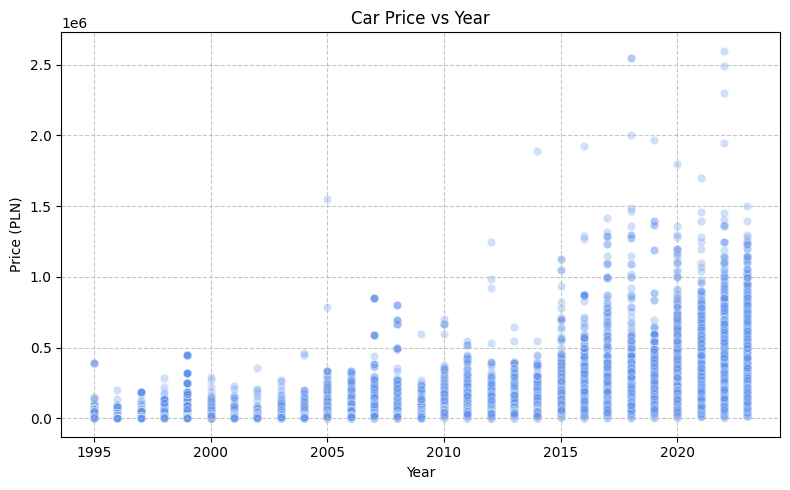

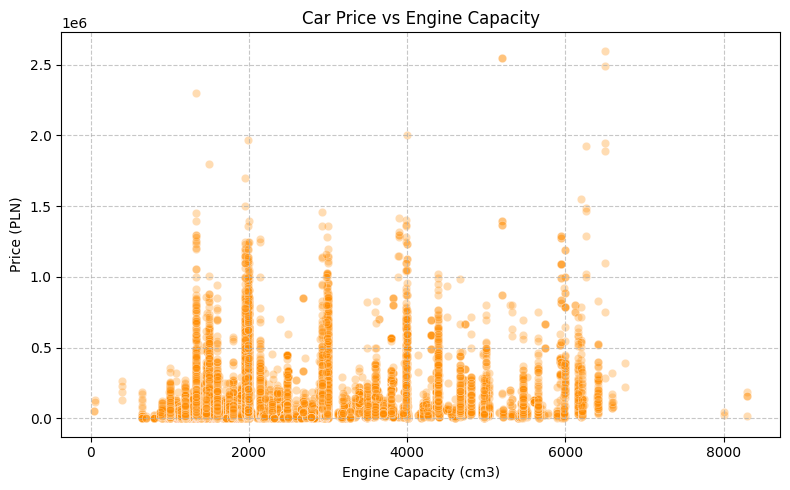

In [10]:
# Price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['price_in_pln'], kde=True, color='green', edgecolor="black")
plt.title("Car Price Distribution")
plt.xlabel("Price (PLN)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mileage distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['mileage'], kde=True, color='cornflowerblue', edgecolor="black")
plt.title("Mileage Distribution")
plt.xlabel("Mileage (km)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Engine Capacity distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['mileage'], kde=True, color='violet', edgecolor="black")
plt.title("Engine Capacity Distribution")
plt.xlabel("Engine Capacity (cm3)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Scatter plot Price vs Mileage
plt.figure(figsize=(8, 5))
sns.scatterplot(x='mileage', y='price_in_pln', data=df, alpha=0.3, color='indianred')
plt.title("Car Price vs Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("Price (PLN)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Scatter plot Price vs Year
plt.figure(figsize=(8, 5))
sns.scatterplot(x='year', y='price_in_pln', data=df, alpha=0.3, color='cornflowerblue')
plt.title("Car Price vs Year")
plt.xlabel("Year")
plt.ylabel("Price (PLN)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Scatter plot Price vs Engine Capacity
plt.figure(figsize=(8, 5))
sns.scatterplot(x='engine_capacity', y='price_in_pln', data=df, alpha=0.3, color='darkorange')
plt.title("Car Price vs Engine Capacity")
plt.xlabel("Engine Capacity (cm3)")
plt.ylabel("Price (PLN)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Boxplots of Numerical Features

The following visualization displays **boxplots** for all numerical features in the dataset. Boxplots are useful for:

* Showing the **distribution and spread** of values
* Highlighting **outliers**
* Comparing **central tendency and variability** across features

This overview helps identify variables with skewed distributions or extreme values that may require special treatment during preprocessing.



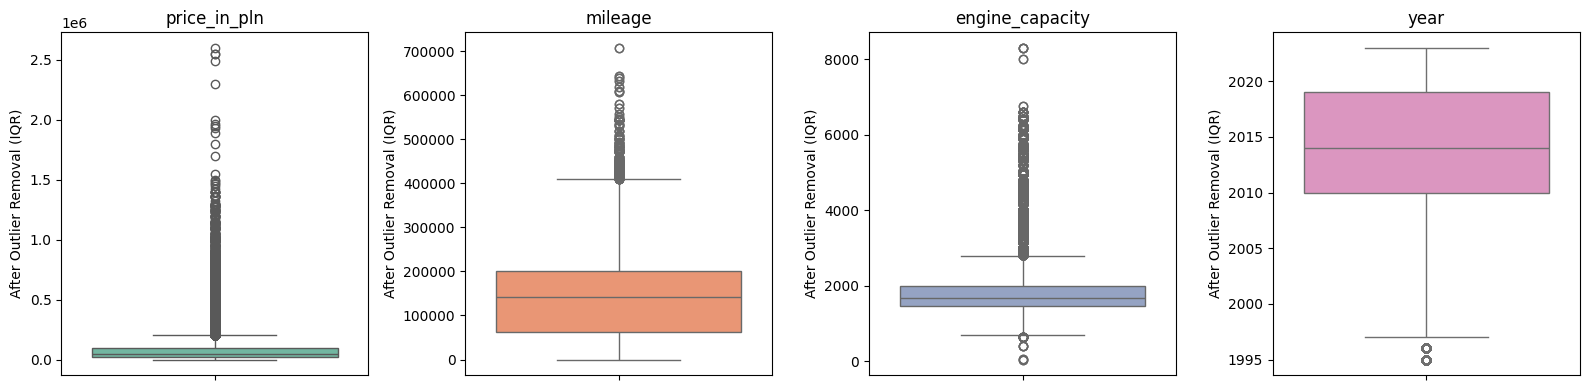

In [11]:
# Selecting numerical columns for boxplot visualization
numerical_cols = df.select_dtypes(include='number').columns
n = len(numerical_cols)


rows = 3  # "before", and "after"
cols = n  # Number of rows needed for the boxplots
palette = sns.color_palette("Set2", n_colors=n)

# Visualizza solo i boxplot degli outlier rimossi tramite IQR
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
for col_idx, col_name in enumerate(numerical_cols):
    sns.boxplot(y=df[col_name], color=palette[col_idx], ax=axes[col_idx])
    axes[col_idx].set_title(col_name)
    axes[col_idx].set_ylabel("After Outlier Removal (IQR)")
    axes[col_idx].set_xlabel("")
plt.tight_layout()
plt.show()


###  Outliers Manual Removal

In [12]:
# Removing luxury cars -> outliers
df = df[df['price_in_pln'] <= 1500000]
# Removing cars with mileage over 600000 -> outliers
df = df[df['mileage'] <= 600000]
# Removing engine capacity clear data errors over 8000 -> outliers
df = df[df['engine_capacity'] <= 8000]
df = df[df['engine_capacity'] > 0]
# Removing duplicate rows
df.drop_duplicates(inplace=True)

### Correlation Matrix
The correlation matrix provides a visual representation of the relationships between numerical features in the dataset. It helps identify:
* **Strong correlations**: Features that are highly correlated with each other, which may indicate redundancy.
* **Weak correlations**: Features that have little to no correlation, suggesting they may provide unique information to the model.

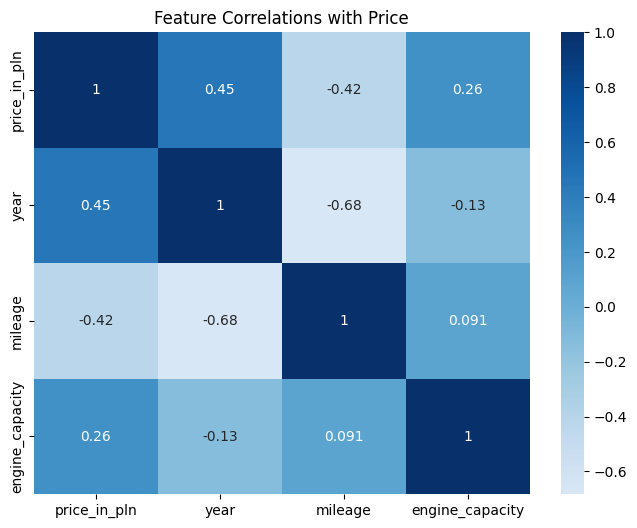

In [9]:
# Calculate correlation matrix
numeric_cols = ['price_in_pln', 'year', 'mileage', 'engine_capacity']
correlation_matrix = df[numeric_cols].corr()

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0)
plt.title('Feature Correlations with Price')
plt.show()

## Feature Selection and Engineering
The feature under the name of *'model'* actually contains a lot of information about the car, therefore we thought it would be helpful to extract the actual model of the car and the configuration of the car. An example of this is: from the string *'Alfa Romeo GTV 2.0 16v TSpark'* we extract *'GTV'* as the model, since the brand is already specified by the first column, and *'2.0 16v TSpark'* as the configuration. The configuration column is later transformed into a numerical, binary, feature by checking whether the configuration is present, 1, or not, 0.

- Encoding categorical features: 
  - One-hot encoding for fuel type and gearbox
  - Target encoding for brand and model (considered as a single feature)
- Scaling numerical features:
  - Min-Max Normalization for numerical features (engine capacity and age)
  - Log normalization for mileage due to skewness

In [13]:
def process_model_name(model, brand):
    model_parts = model.replace('ë', 'e').replace('+', ' ').split()
    brand_words = []
    if brand == 'land-rover':
        brand_words.extend(['land', 'rover', 'range'])
    elif brand.lower() == 'mercedes-benz':
        brand_words.append(brand.replace('-', ' '))
    else:
        brand_words.extend(brand.split('-'))
    
    model_parts_copy = model_parts.copy()
    for w in model_parts_copy:
        w_for_comparison = w.replace('-', ' ')
        if any(brand_part.lower() == w_for_comparison.lower() for brand_part in brand_words):
            model_parts.remove(w)
    
    if len(model_parts) == 0:
        return "Unknown", ""
    
    # Special handling for Land Rover Range Rover
    if brand == 'land-rover' and 'Range' in model and 'Rover' in model:
        original_parts = model.split()
        range_rover_end = -1
        for i, part in enumerate(original_parts):
            if part.lower() == 'rover' and i > 0 and original_parts[i-1].lower() == 'range':
                range_rover_end = i
                break
        if range_rover_end != -1 and range_rover_end + 1 < len(original_parts):
            next_part = original_parts[range_rover_end + 1]
            # Check if the next part is numeric (contains digits)
            if any(char.isdigit() for char in next_part):
                model_name = ['Range', 'Rover']
            else:
                model_name = [next_part]
        else:
            model_name = ['Range', 'Rover']
    else:
        model_name = [model_parts[0]]
    # Special handling for BMW Series
    if brand.lower() == 'bmw' and model_name[0].lower() == 'seria':
        if len(model_parts) > 1:
            model_name.append(model_parts[1])            
    # Special handling for Mercedes-Benz Classes
    if brand.lower() == 'mercedes-benz' and model_name[0].lower() == 'klasa':
        if len(model_parts) > 1:
            model_name.append(model_parts[1])       

    return ' '.join(model_name), ' '.join([w for w in model_parts if w not in model_name])


df['model_cleaned'] = df['model']
df['configuration'] = df['model']
for brand in df['brand'].unique():
    # print(f"Processing brand: {brand}")
    mask = df['brand'] == brand
    # Remove brand name from model
    processed_models = df.loc[mask, 'model_cleaned'].apply(lambda x: process_model_name(x, brand))
    df.loc[mask, 'model_cleaned'] = [result[0] for result in processed_models]
    df.loc[mask, 'configuration'] = [result[1] for result in processed_models]
    # Remove rows where model_cleaned is 'Unknown'
    df = df[df['model_cleaned'] != 'Unknown']
    # Save if has configuration
    df['optional'] = (df['configuration'] != '').astype(int)


# ---------------------- Ordinal encoding for gearbox ----------------------
gearbox_mapping = {value: i for i, value in enumerate(df['gearbox'].unique())}
# # print("Gearbox mapping:", gearbox_mapping)
df['gearbox'] = df['gearbox'].map(gearbox_mapping)


# ---------------------- Dropping useless features ----------------------
df.drop(['city', 'voivodeship'], axis=1, inplace=True)

In [14]:
# Split df in train, val and test sets
X = df.drop('price_in_pln', axis=1)
y = df['price_in_pln']


temp_df, val_df, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
train_df, test_df, y_train, y_test = train_test_split(temp_df, y_temp, test_size=0.075, random_state=42)

print("\nTrain set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


# One hot encode the 'fuel_type' column
encoder = OneHotEncoder(sparse_output=False, drop='first')
fuel_encoded_train = encoder.fit_transform(train_df[['fuel_type']])
feature_names = encoder.get_feature_names_out(['fuel_type'])
fuel_encoded_val = encoder.transform(val_df[['fuel_type']])
fuel_encoded_test = encoder.transform(test_df[['fuel_type']])
train_encoded = pd.DataFrame(fuel_encoded_train, columns=feature_names, index=train_df.index).astype(int)
val_encoded = pd.DataFrame(fuel_encoded_val, columns=feature_names, index=val_df.index).astype(int)
test_encoded = pd.DataFrame(fuel_encoded_test, columns=feature_names, index=test_df.index).astype(int)

train_df = pd.concat([train_df.drop('fuel_type', axis=1), train_encoded], axis=1)
val_df = pd.concat([val_df.drop('fuel_type', axis=1), val_encoded], axis=1)
test_df = pd.concat([test_df.drop('fuel_type', axis=1), test_encoded], axis=1)



# ---------------------- Target encoding for brand and model ----------------------
# Compute target encoding, on training data, for brand and model
train_data = pd.concat([train_df, y_train], axis=1)
brand_model_means = train_data.groupby(['brand', 'model_cleaned'])['price_in_pln'].mean()
def apply_target_encoding(X_set, target_means, fallback_value):
    return X_set.apply(
        lambda row: target_means.get((row['brand'], row['model_cleaned']), fallback_value), 
        axis=1
    )
fallback = y_train.mean()  # Use training mean as fallback
train_df['brand_model_target'] = apply_target_encoding(train_df, brand_model_means, fallback)
val_df['brand_model_target'] = apply_target_encoding(val_df, brand_model_means, fallback)
test_df['brand_model_target'] = apply_target_encoding(test_df, brand_model_means, fallback)



# ---------------------- Normalize mileage, age and engine capacity ----------------------
# Compute age column
last_year = train_df['year'].max()
train_df['age'] = last_year - train_df['year']
val_df['age'] = last_year - val_df['year']
test_df['age'] = last_year - test_df['year']

# In order to avoid data leakage, we will normalize the data ONLY ACCORDING to values in the train set.
max_age = train_df['age'].max()
min_age = train_df['age'].min()
max_mileage = train_df['mileage'].max()
min_mileage = train_df['mileage'].min()
max_engine_capacity = train_df['engine_capacity'].max()
min_engine_capacity = train_df['engine_capacity'].min()

# Normalize mileage, age and engine capacity using train set min and max
train_df['age_normalized'] = (train_df['age'] - min_age) / (max_age - min_age)
val_df['age_normalized'] = (val_df['age'] - min_age) / (max_age - min_age)
test_df['age_normalized'] = (test_df['age'] - min_age) / (max_age - min_age)

train_df['mileage_normalized'] = np.log1p(train_df['mileage'])
val_df['mileage_normalized'] = np.log1p(val_df['mileage'])
test_df['mileage_normalized'] = np.log1p(test_df['mileage'])

train_df['engine_capacity_normalized'] = (df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)
val_df['engine_capacity_normalized'] = (val_df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)
test_df['engine_capacity_normalized'] = (test_df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)

train_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)
val_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)
test_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)

# ---------------------- Save the cleaned data ----------------------
# train_df.to_csv("cars_cleaned.csv", index=False)
train_df.info()


Train set shape: (48946, 10)
Validation set shape: (5880, 10)
Test set shape: (3969, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 48946 entries, 6372 to 51931
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gearbox                     48946 non-null  int64  
 1   optional                    48946 non-null  int64  
 2   fuel_type_Benzyna+CNG       48946 non-null  int64  
 3   fuel_type_Benzyna+LPG       48946 non-null  int64  
 4   fuel_type_Diesel            48946 non-null  int64  
 5   fuel_type_Elektryczny       48946 non-null  int64  
 6   fuel_type_Hybryda           48946 non-null  int64  
 7   brand_model_target          48946 non-null  float64
 8   age_normalized              48946 non-null  float64
 9   mileage_normalized          48946 non-null  float64
 10  engine_capacity_normalized  48946 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 4.5 MB


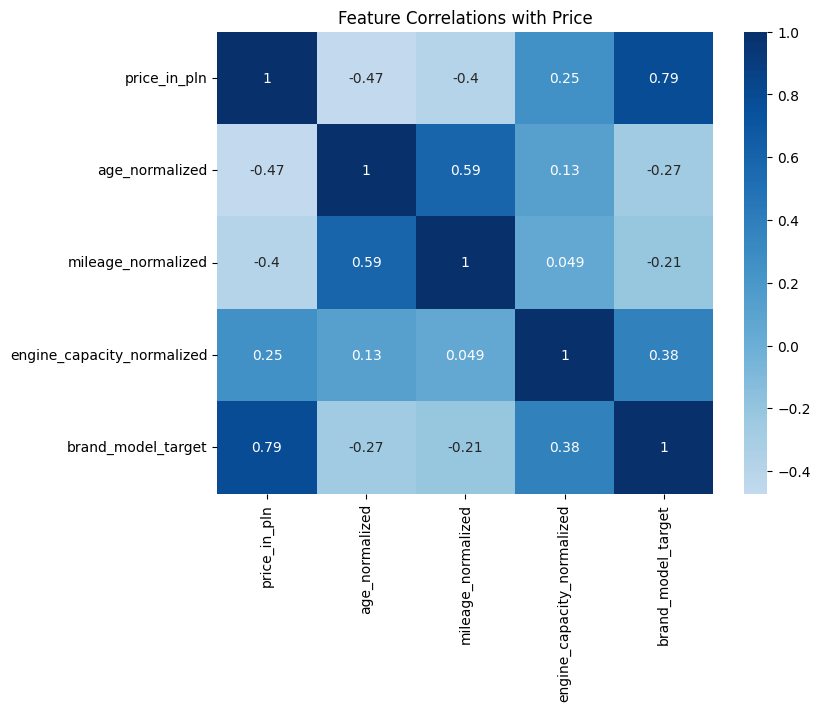

In [15]:
# Calculate correlation matrix
numeric_cols = ['price_in_pln', 'age_normalized', 'mileage_normalized', 'engine_capacity_normalized', 'brand_model_target']
train_data = pd.concat([train_df, y_train], axis=1)
correlation_matrix = train_data[numeric_cols].corr()

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0)
plt.title('Feature Correlations with Price')
plt.show()

## Model Development and Evaluation


In this section, we define a dictionary of machine learning regression models, including decision trees, random forests, gradient boosting, and XGBoost. Each model is associated with a specific hyperparameter grid, which will be used in combination with `GridSearchCV` 

For each model:

* The training is performed using the training set (`train_df`, `y_train`)
* The best model is selected based on the highest R2 score
* Predictions are made on the test set (`test_df`)
* Performance metrics are computed:
  * **MAE** (Mean Absolute Error)
  * **MSE** (Mean Squared Error)
  * **R2 score**
* The trained model is saved using `joblib` for later use





In [21]:
os.makedirs("model_weights", exist_ok=True)
random_state = 42

# Dictionary of models with hyperparameters
models = {
    'DecisionTree': {
        'name': 'Decision Tree',
        'estimator': DecisionTreeRegressor(random_state=random_state),
        'param': [{'max_depth': [5, 10, 20], 'min_samples_split': [10, 12, 15]}]
    },
    'RandomForest': {
        'name': 'Random Forest',
        'estimator': RandomForestRegressor(random_state=random_state),
        'param': {
            'n_estimators': [170, 180, 190, 200],
            'max_depth': [9, 10, 11, 12],
        }
    },
    'GradientBoosting': {
        'name': 'Gradient Boosting',
        'estimator': GradientBoostingRegressor(random_state=random_state),
        'param': {
            'n_estimators': [520, 550, 570, 600],
            'learning_rate': [0.1, 0.15, 0.2],
            'max_depth': [3]
        }
    }, 
    'XGBoost': {
    'name': 'XGBoost Regressor',
    'estimator': XGBRegressor(objective='reg:squarederror', random_state=random_state),
    'param': {
        'n_estimators': [350, 500, 550, 600],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [1.0]
    }
}
}
result = []

for key, model_info in models.items():
    print(f"Training model: {model_info['name']}")
    
    estimator = model_info['estimator']
    param_grid = model_info['param']
    
    if param_grid: 
        grid = GridSearchCV(estimator, param_grid, cv=3, scoring='r2', n_jobs=-1)
        grid.fit(train_df, y_train)
        best_model = grid.best_estimator_
        print(f"Best parameters: {grid.best_params_}")
    
    else:
        best_model = estimator.fit(train_df, y_train)

    # Save the model performance
    dump(best_model, f"model_weights/{key}_model.joblib")
    
    y_pred = best_model.predict(test_df)
    y_pred_train = best_model.predict(train_df)
    
    mae_tr = mean_absolute_error(y_train, y_pred_train)
    mse_tr = mean_squared_error(y_train, y_pred_train)
    r2_tr = r2_score(y_train, y_pred_train)
    
    mae_ts = mean_absolute_error(y_test, y_pred)
    mse_ts = mean_squared_error(y_test, y_pred)
    r2_ts = r2_score(y_test, y_pred)

    result.append({
        'model': model_info['name'],
        'mae_tr': mae_tr,
        'mse_tr': mse_tr,
        'r2_tr': r2_tr,
        'mae_ts': mae_ts,
        'mse_ts': mse_ts,
        'r2_ts': r2_ts,
    })
    print(f"On the training set -> MAE: {mae_tr:.2f}, MSE: {mse_tr:.2f}, R2: {r2_tr:.4f}")
    print(f"On the test set     -> MAE: {mae_ts:.2f}, MSE: {mse_ts:.2f}, R2: {r2_ts:.4f}")
    print("----------------------------------------------\n")


# Show results
results_df = pd.DataFrame(result)
results_df = results_df.sort_values(by='r2_ts', ascending=False)
print("\nModel Performance Summary:")
print(results_df)

best_model_name = results_df.iloc[0]['model']
best_model_key = [k for k, v in models.items() if v['name'] == best_model_name][0]
best_model = load(f"model_weights/{best_model_key}_model.joblib")
dump(best_model, "model_weights/Best_model.joblib")
print(f"\nBest model ({best_model_name}) saved as: model_weights/Best_model.joblib")

Training model: Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_split': 15}
On the training set -> MAE: 20532.68, MSE: 1670064517.64, R2: 0.8783
On the test set     -> MAE: 22518.47, MSE: 2211134970.35, R2: 0.8626
----------------------------------------------

Training model: Random Forest
Best parameters: {'max_depth': 11, 'n_estimators': 180}
On the training set -> MAE: 18337.69, MSE: 1215059719.17, R2: 0.9115
On the test set     -> MAE: 21650.87, MSE: 2101358645.33, R2: 0.8694
----------------------------------------------

Training model: Gradient Boosting
Best parameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 520}
On the training set -> MAE: 20627.79, MSE: 1612241945.11, R2: 0.8825
On the test set     -> MAE: 22287.70, MSE: 2185552439.65, R2: 0.8642
----------------------------------------------

Training model: XGBoost Regressor
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 350, 'subsample': 1.0}
On the training set -> M

### Models Performance on Training and Test Sets
The results just obtained are shown below for an easier reading of the performance of each model on both the whole training and test sets.

**Training Set**

| Model             | MAE       | MSE        | R²    |
| ----------------- | --------- | ---------- | ----- |
| Random Forest     | 18,337.69 | 1.22 × 10⁹ | 0.911 |
| Gradient Boosting | 20,627.79 | 1.61 × 10⁹ | 0.883 |
| Decision Tree     | 20,532.68 | 1.67 × 10⁹ | 0.878 |
| XGBoost Regressor | 21,617.46 | 1.90 × 10⁹ | 0.862 |


**Test Set**

| Model             | MAE       | MSE        | R²    |
| ----------------- | --------- | ---------- | ----- |
| Random Forest     | 21,650.87 | 2.10 × 10⁹ | 0.869 |
| Gradient Boosting | 22,287.70 | 2.19 × 10⁹ | 0.864 |
| Decision Tree     | 22,518.47 | 2.21 × 10⁹ | 0.863 |
| XGBoost Regressor | 23,269.08 | 2.62 × 10⁹ | 0.837 |

## Prediction and Interpretation

This section demonstrates how the trained machine learning models are used to predict car prices on unseen test data. We compare the predictions of different models (Decision Tree, Random Forest, Gradient Boosting, and XGBoost) against the actual prices for a random selection of test samples.

The results are visualized using bar charts, where each sample's true price and predicted prices from all models are shown side by side. This allows for a direct comparison of model performance on individual cases and helps to interpret the strengths and weaknesses of each approach.


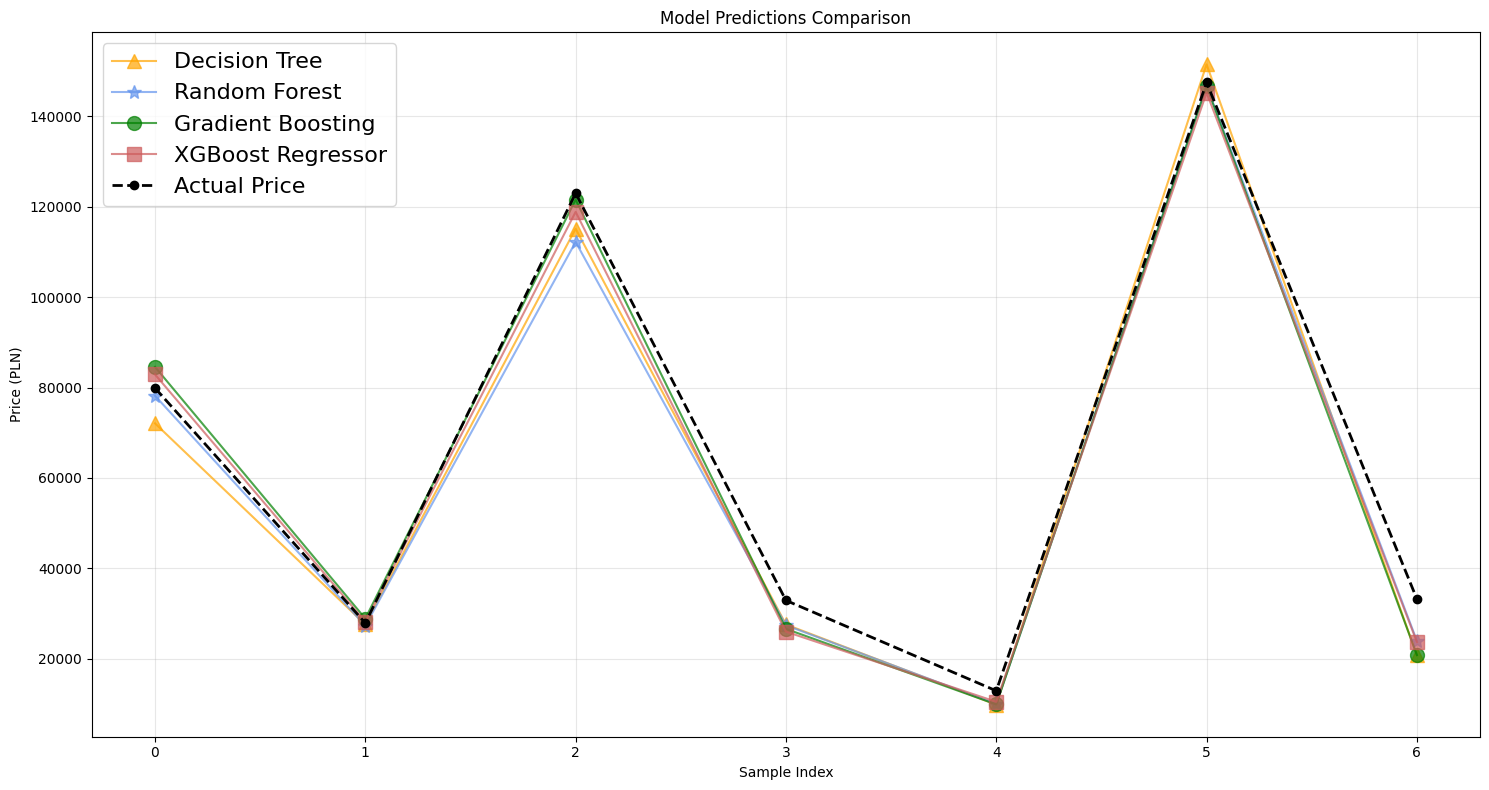

In [128]:
n_samples = 7
random_indices = test_df.sample(n=n_samples, random_state=np.random.randint(0, 10000)).index
x_samples = test_df.loc[random_indices]
y_samples = y_test.loc[random_indices]
comparison_data = []

# Loop through all models and make predictions
for model_key, model_info in models.items():
    model_name = model_info['name']
    model_path = f"model_weights/{model_key}_model.joblib"

    model = load(model_path)
    y_preds = model.predict(x_samples)

    for i, idx in enumerate(random_indices):
        comparison_data.append({
            'model': model_name,
            'sample_index': idx,
            'actual_price': round(y_samples.loc[idx], 2),
            'predicted_price': round(y_preds[i], 2),
            'error': round(y_preds[i] - y_samples.loc[idx], 2)
        })

# Create a comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)
markers = {
    'Decision Tree': '^',
    'Random Forest': '*',
    'Gradient Boosting': 'o',
    'XGBoost Regressor': 's'
}
colors = {
    'Decision Tree': 'orange',
    'Random Forest': 'cornflowerblue',
    'Gradient Boosting': 'green',
    'XGBoost Regressor': 'indianred'
}

plt.figure(figsize=(15, 8))
for model in models:
    model_name = models[model]['name']
    model_data = comparison_df[comparison_df['model'] == model_name]
    plt.plot(range(n_samples), model_data['predicted_price'], marker=markers[model_name], 
             label=f'{model_name}', color=colors[model_name], alpha=0.7, markersize=10)

plt.plot(range(n_samples), y_samples.values, marker='o', label='Actual Price', color='black', 
         linestyle='--', linewidth=2)
plt.title('Model Predictions Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Price (PLN)')
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Load and Evaluation the best model

This cell demonstrates how to load the best-performing model, previously saved after model evaluation, and use it to predict car prices on a random subset of test samples. It not necessary train all models, thanks to gdown the model is downloaded from Google Drive if it's not already present.

Once loaded, the model is used to:

* Predict prices on 7 randomly chosen test samples.
* Print a side-by-side comparison of actual vs. predicted prices.
* Report absolute error and percentage deviation for each sample.

In [18]:
file_id = "1fKIprA1TZNK_GBlmpy-71QkDpGq1AFi0"
output_path = "./RandomForest.joblib"

# Check if weights already exist
if not os.path.exists(output_path):
    print("Downloading model weights...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
    print("Download complete!")
else:
    print("Model weights already exist locally.")
    
# Load the model weights
model = load(output_path)
print("Model weights loaded successfully\n")

Downloading...
From: https://drive.google.com/uc?id=1fKIprA1TZNK_GBlmpy-71QkDpGq1AFi0
To: c:\Users\albon\Desktop\Machine-Learning-Exam\RandomForest.joblib
100%|██████████| 787k/787k [00:00<00:00, 8.41MB/s]

Download complete!
Model weights loaded successfully



In [ ]:
n_test_samples = 7
random_indices = test_df.sample(n=n_samples, random_state=np.random.randint(0, 10000)).index
x_samples = test_df.loc[random_indices]
y_samples = y_test.loc[random_indices]
y_preds = model.predict(x_samples)


print(f"Result for the first {n_test_samples} test samples:")

print("-" * 60)
for i in range(n_test_samples):
    error = abs(y_preds[i] - y_samples.iloc[i])
    error_percent = (error / y_samples.iloc[i]) * 100
    print(f"Sample {x_samples.index[i]}:")
    print(f"  Price Real:    {y_samples.iloc[i]:>10,.2f} PLN")
    print(f"  Price Predicted: {y_preds[i]:>10,.2f} PLN")
    print(f"  Abs. Error: {error:>10,.2f} PLN ({error_percent:.1f}%)")
    print()


Laod pre-trained model...
Result for the first 7 test samples:
------------------------------------------------------------
Sample 54686:
  Price Real:     29,000.00 PLN
  Price Predicted:  30,314.34 PLN
  Abs. Error:   1,314.34 PLN (4.5%)

Sample 57262:
  Price Real:     14,200.00 PLN
  Price Predicted:  12,549.90 PLN
  Abs. Error:   1,650.10 PLN (11.6%)

Sample 64108:
  Price Real:    205,600.00 PLN
  Price Predicted: 137,274.84 PLN
  Abs. Error:  68,325.16 PLN (33.2%)

Sample 65479:
  Price Real:     18,500.00 PLN
  Price Predicted:  21,935.88 PLN
  Abs. Error:   3,435.88 PLN (18.6%)

Sample 33317:
  Price Real:     99,900.00 PLN
  Price Predicted:  96,777.64 PLN
  Abs. Error:   3,122.36 PLN (3.1%)

Sample 17211:
  Price Real:     35,900.00 PLN
  Price Predicted:  41,586.56 PLN
  Abs. Error:   5,686.56 PLN (15.8%)

Sample 53598:
  Price Real:     13,999.00 PLN
  Price Predicted:  13,145.78 PLN
  Abs. Error:     853.22 PLN (6.1%)



The results just obtained are shown below for an easier reading of the performance of the best model over 7 randomly chosen samples.
| Sample ID | Real Price | Predicted Price | Absolute Error | Error (%) |
| --------- | ---------- | --------------- | -------------- | --------- |
| 0         | 29,000.00  | 30,314.34       | 1,314.34       | 4.5       |
| 1         | 14,200.00  | 12,549.90       | 1,650.10       | 11.6      |
| 2         | 205,600.00 | 137,274.84      | 68,325.16      | 33.2      |
| 3         | 18,500.00  | 21,935.88       | 3,435.88       | 18.6      |
| 4         | 99,900.00  | 96,777.64       | 3,122.36       | 3.1       |
| 5         | 35,900.00  | 41,586.56       | 5,686.56       | 15.8      |
| 6         | 13,999.00  | 13,145.78       | 853.22         | 6.1       |

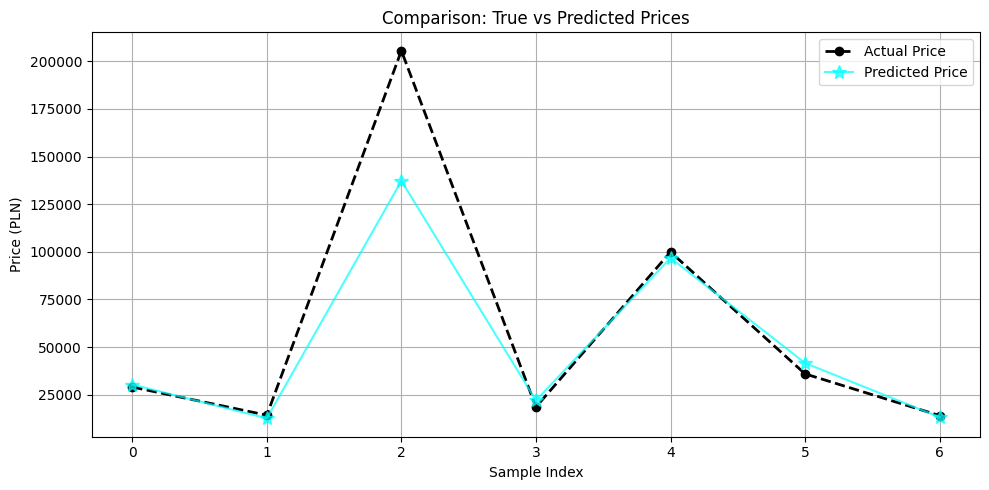

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(range(n_samples), y_samples.values, marker='o', label='Actual Price', 
         color='black', linestyle='--', linewidth=2)
plt.plot(y_preds, label="Predicted Price", marker='*', color='cyan', alpha=0.7, markersize=10)
plt.title("Comparison: True vs Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price (PLN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()